## <h3 align="center">Statistical Analysis and Modeling of Neural Data (NEU 560)</h3>
<h4 align="center">Princeton University, Spring 2018</h4>
<h4 align="center">Jonathan Pillow & Mike Morais</h4>

---
## Homework 4: Gaussian Process Regression & Latent Variable Models 
#### Due: Mon 5/7 at 11:59pm



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)
%autosave 1
%matplotlib inline

Autosaving every 1 seconds


---
## 1) GP regression for place field estimation

The file `rat1Dtrackdata.mat` contains simulated calcium fluorescence data from a rat hippocampal neuron while the rat is running on a 1D track. It contains three variables:  

`tpos` - time bin (in seconds)
`xpos` - the animal's position along the track (in cm)
`dFoverF` - the measured fluorescence signal relative to background (arbitrary units).

For this problem you will use Gaussian process regression to estimate a smooth estimate of the neuron's place field.


**a)**  Load the data and make two plots: one showing the animal's spatial position as a function of time, and a second showing the measured fluorescence (dFoverF) as a function of the animal's position

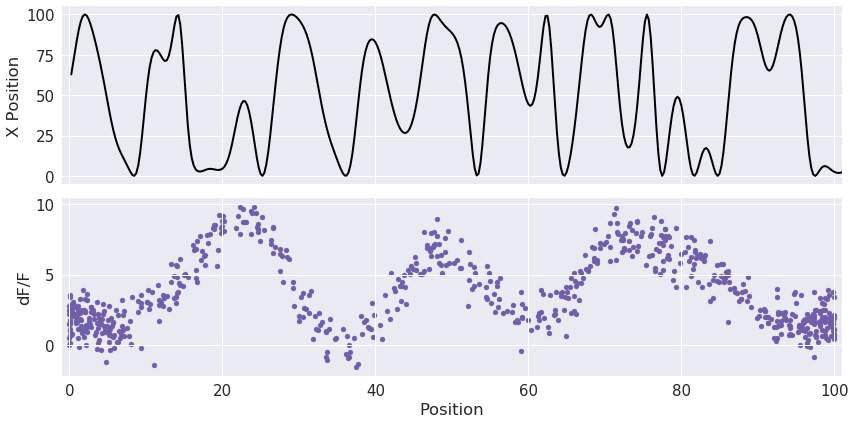

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = loadmat('rat1Dtrackdata.mat')
tpos = data['tpos'].squeeze()
xpos = data['xpos'].squeeze()
dFoverF = data['dFoverF'].squeeze()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6),sharex=True)

## Plot spatial position.
axes[0].plot(tpos, xpos, lw=2, color='k')
axes[0].set(ylabel='X Position')

## Plot dF/F as a function of xpos.
axes[1].scatter(xpos, dFoverF, s=25, color='#705eaa', zorder=0)
axes[1].set(xlim=(xpos.min()-1, xpos.max()+1), xlabel='Position', ylabel='dF/F')

sns.despine()
plt.tight_layout()

**b)** Write a function to compute the log marginal likelihood of the data (the probability of the fluorescence data given the spatial position) using a Gaussian or RBF kernel.  To remind you (see the notes if you need a reminder), the GP regression model is:

$$ y(t) = f(x(t)) + \epsilon(t) $$

$$f \sim GP(0,k) $$

$$ \epsilon(t) \sim \mathcal{N}(0,\sigma^2) $$

The marginal likelihood for the GP regression model is therefore given by:

$$ p(Y|X,\theta) = \mathcal{N}(Y\mid0,K(X,X)+\sigma^2 I) $$

where $K$ is the covariance matrix of the function values $\{f(x_i)\}$ at all points $\{x_i\}$, given by evaluating the kernel function $k$ at all pairs of points $(x_i,x_j)$ in $X$, and $\theta$ are the model hyperparameters, given by $\sigma^2$ (the variance of the additive noise), and the parameters $\rho, \delta$ of the covariance function: 

$$ k(x_i, x_j) = \rho \exp(-\frac{1}{2\delta^2} ||x_i-x_j||^2) $$

where $\rho$ is marginal variance and $\delta$ is the length scale.

Your function should take in $Y$, $X$, and $\theta$ and return $\log P(Y|X,\theta)$.

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def rbf(x, y, delta, rho):
    
    ## Compute distance between coordinates.
    rr = np.subtract( *np.meshgrid(x, y, indexing='ij') )
    
    ## Return RBF.
    return rho * np.exp(-0.5 * (rr/delta)**2)

def GP_rbf_ngl(params, X, Y):
    
    ## Distribute parameters.
    delta, rho, sigma = params
    
    ## Compute covariance.
    n = Y.size
    K = rbf(X, X, delta, rho)
    Sigma = K + sigma ** 2 * np.eye(n)
    Omega = np.linalg.inv(Sigma)
    _, logdet = np.linalg.slogdet(Sigma)
    
    ## Compute log-likelihood.
    log_lik = -0.5 * (logdet + Y.T @ Omega @ Y + n * np.log(2 * np.pi))
            
    return -log_lik  

**c)** Use `scipy.optimize` to find the maximum-likelihood estimate of the hyperparameters $\theta$ using the function you wrote above.

In [4]:
from scipy.optimize import minimize

## Definite initial parameters.
x0 = [1, 1, 1]

## Fit parameters.
fit = minimize(GP_rbf_ngl, x0=x0, args=(xpos, dFoverF), method='L-BFGS-B')
print('Convergence = %s' %fit.success)

## Extract best-fitting parameters.
delta, rho, sigma = fit.x

Convergence = True


**d)** Compute the posterior mean of the cell's place field $f$ on a grid of evenly spaced points from $x=0$ to $x=100$.  To do this, you'll compute the mean of the conditional distribution $P(Y^{grid} | X^{grid}, X, Y, \hat \theta)$, where $X$ and $Y$ are your training data, and $\hat \theta$ is the estimated hyperparameters from the previous step. Make a plot showing the raw data overlaid on top of the posterior mean as a function of your grid of $X$ values.

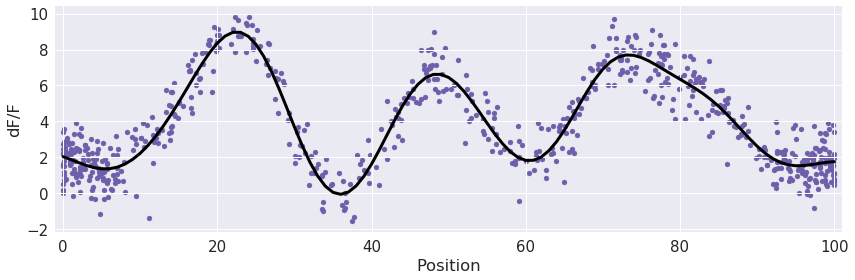

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute posterior mean.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize grid.
xgrid = np.linspace(0,100,101)

## Define covariance matrices.
K_train = rbf(xpos, xpos, delta, rho)
K_test = rbf(xgrid, xpos, delta, rho)

## Solve for mean.
mu = np.linalg.solve(K_train + sigma ** 2 * np.eye(xpos.size), dFoverF)
Kmu = K_test @ mu

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot dF/F as a function of xpos.
ax.scatter(xpos, dFoverF, s=25, color='#705eaa', zorder=0)
ax.plot(xgrid, Kmu, lw=3, color='k')
ax.set(xlim=(xpos.min()-1, xpos.max()+1), xlabel='Position', ylabel='dF/F')

sns.despine()
plt.tight_layout()

---
## 2) Spike sorting of extracellular neural recordings

The gold standard of electrophysiology is high signal-to-noise ratio of an active, well-isolated neuron, but extracellular recordings, by their nature, tend to detect activity of several neurons surrounding the probe. The post-processing problem of identifying which spike came from which neuron is called *spike sorting*, and it's fundamentally the same latent variable recognition problem we've developed in class.

Spike sorting is not a solved problem, but the current state-of-the-art spike sorting algorithms tend to follow the same procedure:

<img src="spikesorting.jpg">

We've already performed steps **(i)** and **(ii)** for you, since digital filtering is something of an art more than a science. In general, we'll use a finite impulse-response bandpass filter. Spike detection (as employed here) tends to use a threshold-crossing procedure. Every time the voltage trace crosses a negative threshold, set here at -65 mV, we grab 48 samples and align the spikes to this threshold crossing.

Load the file `extracellrec.mat`, which contains multiunit extracellular recordings from a single electrode. A single variable `spkwf` loads, an 80397 x 48 matrix of 80397 spikes over 48 time points, aligned to their negative threshold crossing pre-spike.

For multielectrode data such as that from 10x10 Utah arrays, we can imagine repeating the procedure over and over. However, for electrodes very close to each other, such as in hippocampal tetrodes and multilead electrode shanks, the same neuron can appear on multiple electrodes, demanding a source localization technique but dramatically amplifying signal efficacy. For those interested, modern tech like the UCL NeuroPixel [http://www.ucl.ac.uk/neuropixels] or the NeuroSeeker silicon polytrode [http://www.kampff-lab.org/validating-electrodes/] are pushing the boundary in exciting ways.

**a)** Plot 100 random waveforms from this set. How many neurons does it seem like this electrode detected?

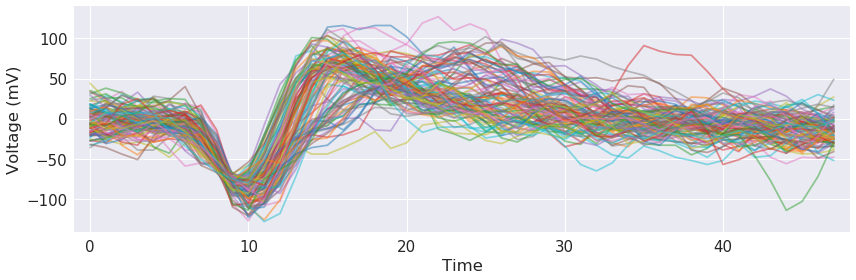

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

data = loadmat('extracellrec.mat')
Stim = data['spkwf']
n_spk = Stim.shape[0]
T = Stim.shape[1]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot waveforms.
ax.plot(Stim[np.random.choice(np.arange(n_spk), 100, replace=False)].T, alpha=0.5)
ax.set(xlim=(-1,48), xlabel='Time', ylabel='Voltage (mV)')

sns.despine()
plt.tight_layout()

**Answer:** It appears the electrode has detected two neurons. We make this inference based on the waveform of the spikes following depolarization. It appears that the recovery following spiking (i.e. hyperpolarization) is prolonged for some, but not all, of the traces.

**b) Feature extraction.** Each spike, then, is a 48-dimensional vector, which in most applications is more data than we need to solve the problem. Write a function `ppca` to project the data down to fewer dimensions using Probabilistic Principal Components Analysis.

In [7]:
def ppca_reduction(X, m=None):
    '''
    Dimensionality reduction with probabilistic PCA.
    
    Parameters
    ----------
    X : 2d array
      Observations (n_obs, n_features)
    m : int
      Number of dimensions to project to.
    
    Returns
    -------
    Y : 2d array
      Reduced data
    '''

    ## Define metadata.
    _, d = X.shape
    if m is None: m = d

    ## Compute sample covariance.
    S = np.cov(X.T)    

    ## Compute principal eigenvectors / eigenvalues.
    U, s, _ = np.linalg.svd(S)

    ## Prepare eigenvectors.
    U = U[:,:m]

    ## Prepare eigenvalues.
    if d == m: var = 0
    else: var = np.sum(s[m:]) / (d - m)
    
    S = np.diag( np.sqrt( s[:m] - var ) )

    ## Return eigenvectors, eigenvalues.
    return U, S

**c)** Project the data down to two dimensions. Since we have a lot of spikes, rather than scatter-plotting the resulting data, make a 2-dimensional histogram and plot it as a heatmap. Now how many neurons does it seem like this electrode detected?

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


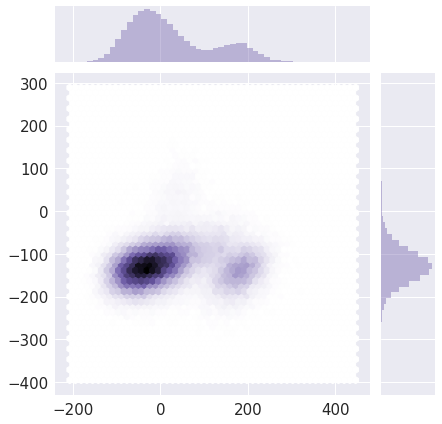

In [8]:
## Dimensionality reduction.
U, _ = ppca_reduction(Stim, 2)
Stim_D2 = np.apply_along_axis(lambda arr: arr - arr.mean(), -1, Stim) @ U

## Plotting (w/ Seaborn).
g = sns.jointplot(*Stim_D2.T, kind='hex', stat_func=None, color='#705eaa')

**Answer:** It still appears like two distinct neurons, though there appears to be some mass between the two dominant clusters.

**d)** Plot these first two principal components. What information do they seem to capture about the temporal dynamics of the spikes?

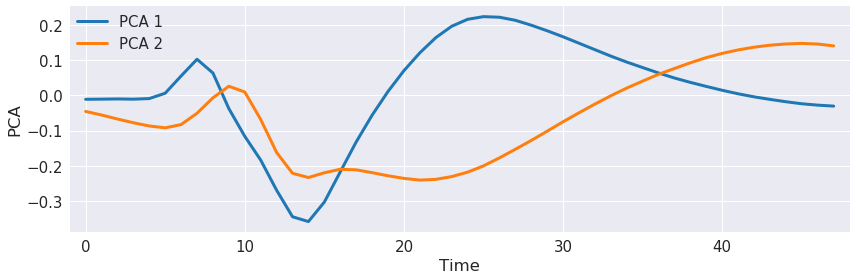

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot principal components.
for i, u in enumerate(U.T): ax.plot(u, lw=3, label='PCA %s' %(i+1))
ax.set(xlim=(-1,48), xlabel='Time', ylabel='PCA')
ax.legend(loc=2, borderpad=0)

sns.despine()
plt.tight_layout()

**Answer:** The first component seems to capture the overall spike waveform for the data. The second component seems to capture temporal differences in the waveform. Specifically, the second principal component seems to capture a prolonged hyperpolarization phase following spiking, consistent with the raw traces above.

**e) Clustering.** Implement your own version of k-means clustering, and use it to identify clusters in these data.  (You may wish to compare the performance of your algorithm to  `sklearn.cluster.KMeans` to make sure it is performing correctly).  

Perform k-means clustering for several different `k` and scatter plot your best results, colorizing each spike with the cluster to which it was assigned. 

_(Mike's style recommendation: use colors c=[1,0,0], [0,1,0], or [0,0,1] (if you find three clusters, or any pair if you find two clusters) for reasons that will make more sense in the next section)_

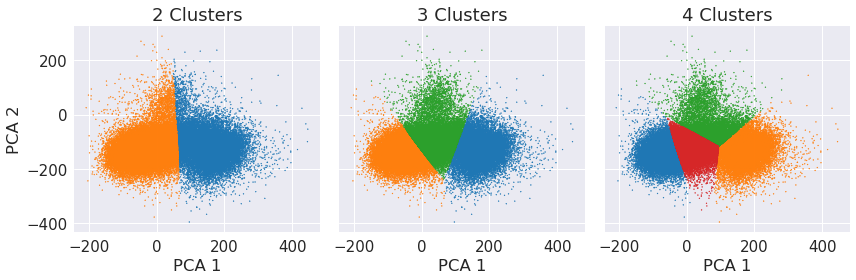

In [10]:
from sklearn.metrics import pairwise_distances_argmin

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

def KMeansEM(X, k=2, n_iter=100):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Initialization.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Define metadata.
    N, _ = X.shape
    
    ## Initialize cluster centers.
    centers = X[np.random.choice(np.arange(N), k)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Main loop.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    for _ in np.arange(n_iter):
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### E-step.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
        ## Assign labels given closest center.
        labels = pairwise_distances_argmin(X, centers)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### M-step.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
        ## Update centers.
        centers = np.array([X[labels==i].mean(axis=0) for i in np.unique(labels)])
    
    return centers, labels

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

for ax, k in zip(axes.flatten(), [2,3,4]):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Fit K-means clustering.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Fit KMeans.
    centers, labels = KMeansEM(Stim_D2, k=k, n_iter=100)

    ## Sort data by labels.
    copy = Stim_D2[np.argsort(labels)].copy()
    labels = labels[np.argsort(labels)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Plot data points.
    colors = [sns.color_palette(n_colors=k)[i] for i in labels]
    ax.scatter(*copy.T, s=1, color=colors)
    ax.set(xlabel='PCA 1', title='%s Clusters' %k)
    if k == 2: ax.set_ylabel('PCA 2')
    
plt.tight_layout()

### Ground Truth w/ `sklearn.cluster.KMeans`

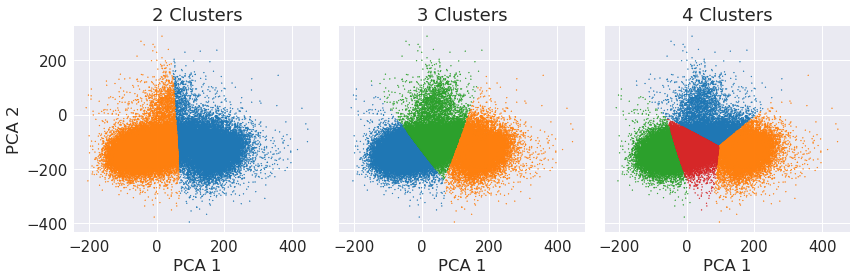

In [11]:
from sklearn.cluster import KMeans

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

for ax, k in zip(axes.flatten(), [2,3,4]):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Fit K-means clustering.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Fit KMeans.
    kmeans = KMeans(n_clusters=k).fit(Stim_D2)    
    labels = kmeans.predict(Stim_D2)

    ## Sort data by labels.
    copy = Stim_D2[np.argsort(labels)].copy()
    labels = labels[np.argsort(labels)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Plot data points.
    colors = [sns.color_palette(n_colors=k)[i] for i in labels]
    ax.scatter(*copy.T, s=1, color=colors)
    ax.set(xlabel='PCA 1', title='%s Clusters' %k)
    if k == 2: ax.set_ylabel('PCA 2')
    
plt.tight_layout()

**f)** Write a function to use the EM algorithm to fit a mixture of Gaussians to these data. Use random initial conditions for several different `k` and scatter plot your best results as you did for k-means. How do these results compare?

_(Mike's follow-up style recommendation: You can colorize each point with $c_i$=[$Pr(z_i=1\mid x_i)$, $Pr(z_i=2\mid x_i)$,...] to visualize points that weren't overwhelmingly members of one cluster versus another. It looks cool to visualize the transition!)_

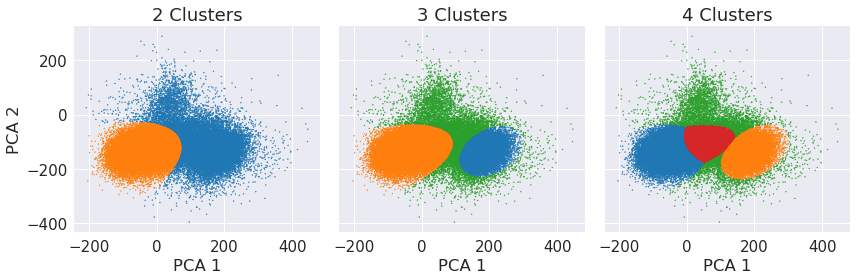

In [12]:
from scipy.stats import multivariate_normal

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def MixtureOfGaussiansEM(X, k=2, n_iter=100, init_centers=None, 
                         init_covs=None, init_w=None):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Initialization.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Define metadata.
    N, _ = X.shape
    
    ## Initialize cluster means.
    if init_centers is None: 
        centers = X[np.random.choice(np.arange(N), k)]
    else:
        centers = init_centers
    
    ## Initialize cluster covariances.
    if init_covs is None:
        covs = np.array([np.eye(2) for _ in np.arange(k)])
    else:
        covs = init_covs
    
    ## Initialize mixing weights.
    if init_w is None:
        w = np.ones(k) / k
    else:
        w = init_w
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Main loop.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    for _ in np.arange(n_iter):
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### E-step.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
        ## Compute likelihood of each sample belonging
        ## to each cluster.
        p = np.zeros((k, N))
        for i in np.arange(k):
            p[i] = w[i] * multivariate_normal(centers[i], covs[i]).pdf(X)
        
        ## Normalize probabilities.
        p = np.divide(p, p.sum(axis=0), where=p.sum(axis=0) > 0)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### M-step.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
        ## Update parameters.
        for i in np.arange(k):
            
            ## Update mean.
            centers[i] = p[i] @ X / p[i].sum()    
            
            ## Update covariance.
            covs[i] = p[i] * (X - centers[i]).T @ (X - centers[i]) / p[i].sum()
        
            ## Update mixing weights.
            w[i] = p[i].sum() / N
    
    return centers, covs, w

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

for ax, k in zip(axes.flatten(), [2,3,4]):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Fit mixture of Gaussians.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Define initial conditions.
    init_covs = np.array([1000 * np.eye(2) for _ in np.arange(k)])
    
    ## Fit MoG.
    centers, covs, w = MixtureOfGaussiansEM(Stim_D2, k=k, n_iter=500,
                                            init_covs=init_covs)

    ## Predict labels.
    p = np.zeros((k, Stim_D2.shape[0]))
    for i in np.arange(k):
        p[i] = w[i] * multivariate_normal(centers[i], covs[i]).pdf(Stim_D2)
    p = np.divide(p, p.sum(axis=0), where=p.sum(axis=0) > 0).T
    labels = np.argmax(p, axis=-1)
    
    ## Sort data by labels.
    copy = Stim_D2[np.argsort(labels)].copy()
    labels = labels[np.argsort(labels)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Plot data points.
    colors = [sns.color_palette(n_colors=k)[i] for i in labels]
    ax.scatter(*copy.T, s=1, color=colors)
    ax.set(xlabel='PCA 1', title='%s Clusters' %k)
    if k == 2: ax.set_ylabel('PCA 2')
        
plt.tight_layout()

### Ground Truth w/ `sklearn.cluster.GaussianMixture`

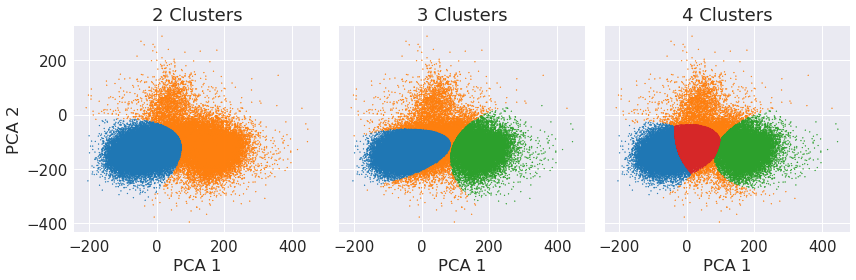

In [13]:
from sklearn.mixture import GaussianMixture

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)

for ax, k in zip(axes.flatten(), [2,3,4]):

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Fit K-means clustering.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Fit KMeans.
    gm = GaussianMixture(n_components=k).fit(Stim_D2)    
    labels = gm.predict(Stim_D2)

    ## Sort data by labels.
    copy = Stim_D2[np.argsort(labels)].copy()
    labels = labels[np.argsort(labels)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Plot data points.
    colors = [sns.color_palette(n_colors=k)[i] for i in labels]
    ax.scatter(*copy.T, s=1, color=colors)
    ax.set(xlabel='PCA 1', title='%s Clusters' %k)
    if k == 2: ax.set_ylabel('PCA 2')
    
plt.tight_layout()

**Answer:** The mixture of Gaussians model seems to provide a better fit of the data. Specifically, it respects the contours of the cluster masses, rather than dividing them along arbitrary boundaries. In general, 2-3 clusters for the mixture of Gaussians seems to provide the most natural fit, consistent with the observations above.